In [280]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize

In [91]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [92]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [93]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [94]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [95]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [442]:
def plotDynamics(tSlice,mSlice,rSlice,coeff,dynamicBins):

    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)

    #abs
    tSlice = np.abs(tSlice)
    mSlice = np.abs(mSlice)
    rSlice = np.abs(rSlice)



    #Level
    tLevel.plot(np.abs(tSlice),label="Unmatched")
    tLevel.plot(np.abs(mSlice),label="Matched")
    rLevel.plot(np.abs(rSlice))

    tLevel.set_title('Target')
    tLevel.set_ylabel("Level")
    tLevel.legend()
    rLevel.set_title('Reference')
    rLevel.set_xlabel("Frame")
    rLevel.set_ylabel("Level")
    


    #Response
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tSlice, rSlice, dynamicBins)
    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heatmap(reshape, ax=tResponse, cmap="magma")
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heatmap(reshape, ax=rResponse, cmap="magma")
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)

    mDynamicResponse, mrDynamicResponse = getDynamicResponse(mSlice, rSlice, dynamicBins)
    reshape = np.flip(mDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heatmap(reshape, ax=mResponse, cmap="magma")
    reshape = np.flip(mrDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heatmap(reshape, ax=mrResponse, cmap="magma")
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    preDist.set_title('Distance:')
    postDist.set_title('Distance:')
    preDist.axis("off")
    postDist.axis("off")
    preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")

    #Modifier
    tMax = max(np.abs(tSlice))
    x = np.linspace(0,tMax,100)
    plotCoeff = np.append(coeff[::-1],0)
    y = np.polyval(plotCoeff,x)

    mod.plot(x,x, color='gray')
    mod.plot(x,y, color='red')
    
    mod.set_title('Modifier')
    mod.set_xlabel("Target Level")
    mod.set_ylabel("Matched Level")

In [143]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # abs
    tAbs = np.abs(tFreqBin)
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

In [98]:
def matchBin(tSlice, rSlice, dynamicBins, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
    tMax = max(np.abs(tSlice))
    rMax = max(np.abs(rSlice))
    distance = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    tAvg = statistics.mean(np.abs(tSlice))
    rAvg = statistics.mean(np.abs(rSlice))
    scaler = rAvg / tAvg
    
    if(tempscaler[0]==None):
        mSlice = warp(tSlice, [scaler])
    else:
        mSlice = warp(tSlice, tempscaler)

    return mSlice


def dynamicMatching(tAudio,rAudio,dynamicBins, plotBin, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    tMax = max(np.abs(tAudio["STFT"][plotBin,:]))
    rMax = max(np.abs(rAudio["STFT"][plotBin,:]))
    preDist = getDistance(tDynamicResponse, rDynamicReponse,tMax,rMax)
    print("unmatched distance:",preDist)
    plotDynamics(tAudio, rAudio, dynamicBins, plotBin, matched=False)

    # Matching happens on a copied version of the target, to ensure the original target is preserved
    mAudio = copy.deepcopy(tAudio)

    for bin in range(len(rAudio["STFT"])):
        tSlice = tAudio["STFT"][bin,:]
        rSlice = rAudio["STFT"][bin,:]

        mSlice = matchBin(tSlice, rSlice, dynamicBins, tempscaler)
        mAudio["STFT"][bin,:] = mSlice
    
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    mMax = max(np.abs(mAudio["STFT"][plotBin,:]))
    postDist = getDistance(mDynamicResponse, rDynamicReponse, mMax, rMax)
    print("matched distance:  ",postDist)
    print("difference: ",preDist/postDist)
    plotDynamics(mAudio, rAudio, dynamicBins, plotBin, matched=True)

    return mAudio

In [450]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlice, rSlice, dynamicBins = params

    mSlice = warp(tSlice, x)
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
    mMax = max(np.abs(mSlice))
    rMax = max(np.abs(rSlice))
    
    return getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax)

# perform dual annealing
def findMin(tSlice,rSlice,dynamicBins):
    order = 3
    searchSize = 100
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    return sol['x']

def matchBin(tAudio,rAudio,bin,dynamicBins):
    tSlice = tAudio["STFT"][bin,:]
    rSlice = rAudio["STFT"][bin,:]
    
    coeff = findMin(tSlice,rSlice,dynamicBins)
    mSlice = warp(tSlice, coeff)

    plotDynamics(tSlice, mSlice, rSlice, coeff, dynamicBins)
    


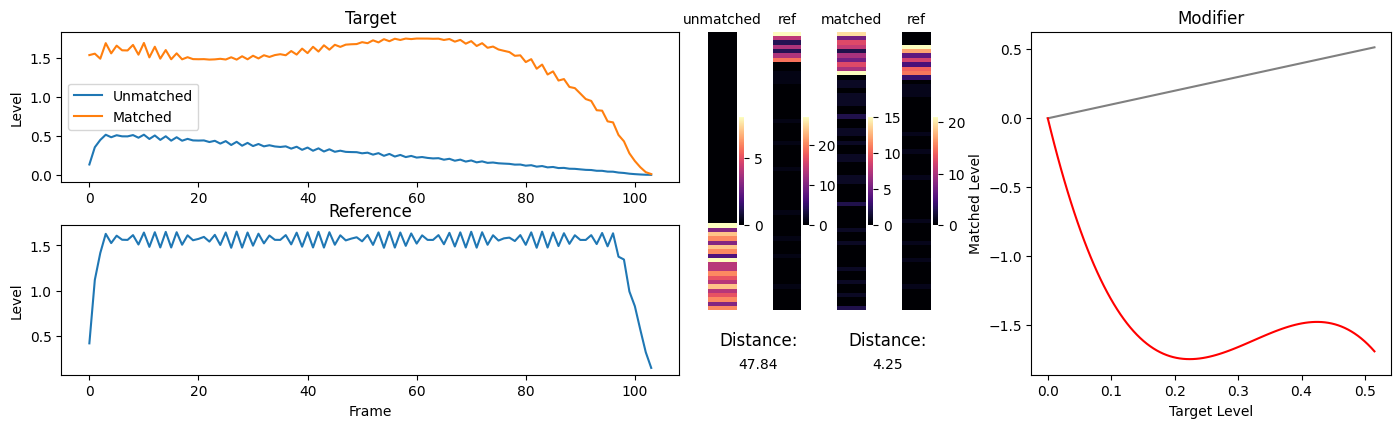

In [451]:
matchBin(tAudio,rAudio,100,64)

In [ ]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

<h1>Execution</h1>

In [ ]:
frameSize=2048
hopSize=512

figScale = 1

In [156]:
tAudio, rAudio = importAudio(target="tonequiet.wav",reference="toneloud.wav", output=False)
#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

#mAudio = dynamicMatching(tAudio,rAudio,dynamicBins=64, plotBin=100, tempscaler=[-9.113e+00,9.998e+00,9.538e+00,-6.070e+00,-8.379e+00])
#bruteForceMatching(tAudio,rAudio,dynamicBins=4, freqBin=100, testDistance=10, steps=100)

#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)

#plotSpectrogram(tAudio, mAudio, rAudio)

#exportAudio(tAudio, mAudio, rAudio)